<a href="https://colab.research.google.com/github/JuanDavid1217/Generative-AI-from-Scratch/blob/main/Transformers/Embedding_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Primero se necesita entender como funcionan lo Embeddings**

In [1]:
import numpy as np
from pickle import load
import pickle

In [2]:
class Activation_ReLU:
  def __init__(self):
    self.input=[]
    self.output=[]
    self.dinputs=[]

  def forward(self, input):
    self.input = input
    self.output=np.maximum(0, input)

  def backward(self, dvalues):
    dvalues = np.sum(dvalues, axis=0, keepdims=True)
    self.dinputs=dvalues*np.where(self.output > 0, 1, 0)

class Activation_Sigmoid:
  def __init__(self):
    self.input=[]
    self.output=[]
    self.dinputs=[]

  def forward(self, input):
    self.output = 1 / (1 + np.exp(-input))

  def backward(self, dvalues):
    self.dinputs = dvalues * (1 - self.output) * self.output

class Activation_SoftMax:
  def __init__(self):
    self.input=[]
    self.output=[]
    self.dinputs=[]

  def forward(self, input):
    exp_z = np.exp(input - np.max(input))
    self.output = exp_z / np.sum(exp_z, axis=0)

  def backward(self, dvalues):
    # Create uninitialized array
    self.dinputs = np.empty_like(dvalues)
    # Enumerate outputs and gradients
    for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
      # Flatten output array
      single_output = single_output.reshape(-1, 1)
      # Calculate Jacobian matrix of the output and
      jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
      # Calculate sample-wise gradient
      # and add it to the array of sample gradients
      self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)



In [3]:
class Dense:
  def __init__(self, input_dim, neurons, bias=False):
    self.weights=0.1*np.random.randn(input_dim, neurons)
    self.bias=bias
    if self.bias:
      self.biases=np.zeros((1, neurons))
      self.dbiases=0
    self.input=[]
    self.output=[]
    self.dweights=0
    self.dinputs=0

  def  forward(self, input):
    self.input=input
    if self.bias:
      self.output = np.dot(self.input, self.weights)+self.biases
    else:
      self.output=np.dot(self.input, self.weights)

  def backward(self, dvalues):
    if self.bias:
      self.dbiases=dvalues
    else:
      if dvalues.shape[0]!=1:
        dvalues=dvalues.reshape(1, -1)

    if self.input.shape[0]!=1:
        self.input=self.input.reshape(1, -1)
    self.dweights=np.dot(self.input.T, dvalues)
    self.dinputs=np.dot(dvalues, self.weights.T)


In [4]:
class Optimizer_Adam:
  def __init__(self, learning_rate=0.01, decay=0., epsilon=1e-7,beta_1=0.9, beta_2=0.999):
    self.learning_rate = learning_rate
    self.current_learning_rate = learning_rate
    self.decay = decay
    self.iterations = 0
    self.epsilon = epsilon
    self.beta_1 = beta_1
    self.beta_2 = beta_2


  def pre_update_params(self):
    if self.decay:
      self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

  def update_params(self, layer):
    if not hasattr(layer, 'weight_cache'):
      layer.weight_momentums = np.zeros_like(layer.weights)
      layer.weight_cache = np.zeros_like(layer.weights)
      if hasattr(layer, 'biases'):
        layer.bias_momentums = np.zeros_like(layer.biases)
        layer.bias_cache = np.zeros_like(layer.biases)

    # Update momentum with current gradients
    layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
    if hasattr(layer, 'biases'):
      layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases
    # Get corrected momentum
    # self.iteration is 0 at first pass
    # and we need to start with 1 here
    weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
    if hasattr(layer, 'biases'):
      bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))
    # Update cache with squared current gradients
    layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
    if hasattr(layer, 'biases'):
      layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2
    # Get corrected cache
    weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
    if hasattr(layer, 'biases'):
      bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))
    # Vanilla SGD parameter update + normalization
    # with square rooted cache
    layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
    if hasattr(layer, 'biases'):
      layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

  # Call once after any parameter updates
  def post_update_params(self):
    self.iterations += 1


class Rmsprop:
  def __init__(self, learning_rate=0.1, decay=0., epsilon=1e-8, rho=0.9):
    self.learning_rate = learning_rate
    self.current_learning_rate = learning_rate
    self.decay = decay
    self.iterations = 0
    self.epsilon = epsilon
    self.rho = rho

  def pre_update_params(self):
    if self.decay:
      self.current_learning_rate = self.learning_rate * \
          (1. / (1. + self.decay * self.iterations))

  def update_params(self, layer):
    if not hasattr(layer, 'wight_cache'):
      layer.weight_cache = np.zeros_like(layer.weights)
    if hasattr(layer, 'biases'):
      layer.bias_cache = np.zeros_like(layer.biases)

    layer.weight_cache = self.rho * layer.weight_cache + \
        (1 - self.rho) * layer.dweights**2
    if hasattr(layer, 'biases'):
      layer.bias_cache = self.rho * layer.bias_cache + \
          (1 - self.rho) * layer.dbiases**2

    layer.weights += -self.current_learning_rate * \
                    layer.dweights / \
                    (np.sqrt(layer.weight_cache) + self.epsilon)
    if hasattr(layer, 'biases'):
      layer.biases += -self.current_learning_rate * \
                      layer.dbiases / \
                      (np.sqrt(layer.bias_cache) + self.epsilon)
    return layer

  def post_update_params(self):
    self.iterations += 1

In [5]:
class LossBinaryCrossEntropy():
  def forward(self, y_pred, y_true):
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

    sample_losses = -(y_true * np.log(y_pred_clipped) + (1 - y_true) * np.log(1 - y_pred_clipped))
    #sample_losses = np.mean(sample_losses, axis=1)

    return sample_losses

  def backward(self, dvalues, y_true):
    samples = len(dvalues)
    outputs = len(dvalues)

    clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)

    dinputs = -(y_true / clipped_dvalues - (1 - y_true)
                     /(1 - clipped_dvalues))/outputs

    return dinputs / samples

In [66]:
class Embedding:
  def __init__(self, vocab_size, sentence_len, latent_dim):
    self.vocab_size = vocab_size
    self.sentence_len = sentence_len
    self.layer1 = Dense(vocab_size, latent_dim, True)
    self.activationLayer1 = Activation_ReLU()
    self.layer2 = Dense(latent_dim, vocab_size, True)
    self.activationLayer2 = Activation_Sigmoid()
    self.optimizer = Optimizer_Adam(learning_rate=0.0001)#Rmsprop(learning_rate=0.0001)
    self.trainableLayers = [self.layer1, self.layer2]
    self.lossFunction = LossBinaryCrossEntropy()

  def forward(self, input):
    self.layer1.forward(input)
    self.activationLayer1.forward(self.layer1.output)
    self.layer2.forward(self.activationLayer1.output)
    self.activationLayer2.forward(self.layer2.output)
    return self.activationLayer2.output

  def backward(self, loss):
    self.activationLayer2.backward(loss)
    self.layer2.backward(self.activationLayer2.dinputs)
    self.activationLayer1.backward(self.layer2.dinputs)
    self.layer1.backward(self.activationLayer1.dinputs)

  def generateOneHotVector(self, input):
    oneHotVectors = []
    for position in input:
      oneHot = np.zeros(self.vocab_size)
      oneHot[position] = 1
      oneHotVectors.append(oneHot)
    return oneHotVectors

  def get_SumContext(self, vector):
    y_labels=[]
    for i in range(len(vector)):
      contexts=[]
      if i == 0:
        contexts = vector[i+1:i+3]
      else:
        min=i-2
        if min<0:
          min=0
        if len(vector[i+1:i+3])!=0 and len(vector[min:i])!=0:
          contexts = np.concatenate((vector[min:i], vector[i+1:i+3]))
        elif len(vector[i+1:i+3])==0:
          contexts = vector[min:i]
      context=[]
      for array in contexts:
        if len(context)==0:
          context = array
        else:
          context = context + array
      y_labels.append(context)
    return y_labels

  def train(self, input, epoch):
    for i in range(epoch):
      lossByEpoch=0
      for sentence in input:
        lossBySentence=0
        x_labels= self.generateOneHotVector(sentence)
        y_labels = self.get_SumContext(vector=x_labels)
        loss=np.zeros((1, 13))
        for i in range(len(x_labels)):
          prediction = self.forward(x_labels[i])
          #print("prediction: ", prediction)
          #print(f"waited {i}: {x_labels[i]}")
          loss = loss + (prediction - y_labels[i])#self.lossFunction.forward(prediction,x_labels[i])
          self.backward(prediction - y_labels[i])
          self.optimizer.pre_update_params()
          for layer in self.trainableLayers:
            self.optimizer.update_params(layer)
          self.optimizer.post_update_params()
        lossBySentence = loss/len(x_labels)#np.mean(np.sqrt(loss*loss))
        lossByEpoch+=np.mean(lossBySentence)#/len(x_labels)
      print("Loss: ", lossByEpoch/len(input))

  def getEmbedding(self, input):
    oneHotVectors = self.generateOneHotVector(input)
    embeddings = []
    for oneHotVector in oneHotVectors:
      self.layer1.forward(oneHotVector)
      self.activationLayer1.forward(self.layer1.output)
      embeddings.append(self.activationLayer1.output)
    return embeddings



Manejo de datos

In [7]:
# Leer set de entrenamiento
filename = './english-spanish.pkl'

#dataset = load(open(filename, 'rb'))
#print(dataset[120000,0])
#print(dataset[120000,1])
dataset = np.array([np.array(["el rey de Inglaterra es un hombre","the king of England is a man"]),
                    np.array(["la reina de Inglaterra es una mujer","the queen of England is a woman"]),
                    np.array(["Carlos es un rey","Carlos is a king"]),
                    np.array(["Andrea es una reina","Andrea is a queen"]),
                    np.array(["Carlos es un hombre","Carlos is a man"]),
                    np.array(["Andrea es una mujer","Andrea is a woman"])
                    ])
print(dataset[0,1])

the king of England is a man


In [8]:
# Crear "tokens"
source_tokens = []
for sentence in dataset[:,0]:
  source_tokens.append(sentence.split(' '))
print(source_tokens[0])

target_tokens = []
for sentence in dataset[:,1]:
  target_tokens.append(sentence.split(' '))
print(target_tokens[0])

['el', 'rey', 'de', 'Inglaterra', 'es', 'un', 'hombre']
['the', 'king', 'of', 'England', 'is', 'a', 'man']


In [9]:
def build_token_dict(token_list):
  token_dict = {
  #    '<PAD>': 0,
  #    '<START>': 1,
  #    '<END>': 2
  }
  for tokens in token_list:
    for token in tokens:
      if token not in token_dict:
        token_dict[token] = len(token_dict)
  return token_dict

In [10]:
source_token_dict = build_token_dict(source_tokens)
source_token_dict_inv = {v:k for k,v in source_token_dict.items()}
target_token_dict = build_token_dict(target_tokens)
target_token_dict_inv = {v:k for k,v in target_token_dict.items()}

print(source_token_dict)
print(target_token_dict)
print(target_token_dict_inv)

{'el': 0, 'rey': 1, 'de': 2, 'Inglaterra': 3, 'es': 4, 'un': 5, 'hombre': 6, 'la': 7, 'reina': 8, 'una': 9, 'mujer': 10, 'Carlos': 11, 'Andrea': 12}
{'the': 0, 'king': 1, 'of': 2, 'England': 3, 'is': 4, 'a': 5, 'man': 6, 'queen': 7, 'woman': 8, 'Carlos': 9, 'Andrea': 10}
{0: 'the', 1: 'king', 2: 'of', 3: 'England', 4: 'is', 5: 'a', 6: 'man', 7: 'queen', 8: 'woman', 9: 'Carlos', 10: 'Andrea'}


In [11]:
# Agregar start, end y pad a cada frase del set de entrenamiento
#encoder_tokens = [['<START>'] + tokens + ['<END>'] for tokens in source_tokens]
encoder_tokens = [tokens for tokens in source_tokens]
#decoder_tokens = [['<START>'] + tokens + ['<END>'] for tokens in target_tokens]
decoder_tokens = [tokens for tokens in target_tokens]
#output_tokens = [tokens + ['<END>'] for tokens in target_tokens]
output_tokens = [tokens for tokens in target_tokens]

source_max_len = max(map(len, encoder_tokens))
target_max_len = max(map(len, decoder_tokens))

#encoder_tokens = [tokens + ['<PAD>']*(source_max_len-len(tokens)) for tokens in encoder_tokens]
#decoder_tokens = [tokens + ['<PAD>']*(target_max_len-len(tokens)) for tokens in decoder_tokens]
#output_tokens = [tokens + ['<PAD>']*(target_max_len-len(tokens)) for tokens in output_tokens ]

In [12]:
print(encoder_tokens[1])

['la', 'reina', 'de', 'Inglaterra', 'es', 'una', 'mujer']


In [13]:
encoder_input = [list(map(lambda x: source_token_dict[x], tokens)) for tokens in encoder_tokens]
decoder_input = [list(map(lambda x: target_token_dict[x], tokens)) for tokens in decoder_tokens]
output_decoded = [list(map(lambda x: [target_token_dict[x]], tokens)) for tokens in output_tokens]

In [ ]:
print(encoder_input[1])

[7, 8, 2, 3, 4, 9, 10]


Entrenamos el Embedding

In [14]:
vocab_size = len(source_token_dict)
print(vocab_size)
print(target_max_len)
print(len(decoder_input))

13
7
6


In [210]:
embedding = Embedding(vocab_size, source_max_len, 2)

In [211]:
# Después de varia pruebas notamos que con un learning_rate de 0.0001 y 1200 epoch la diferencia de resultados
# entre entrenamientos se reduce considerablemente.
embedding.train(encoder_input, 1200)

Loss:  0.29111866769006334
Loss:  0.29067112603138173
Loss:  0.2902212697797371
Loss:  0.28977216859945604
Loss:  0.2893239173141066
Loss:  0.28887647542157585
Loss:  0.28842978025532623
Loss:  0.28798376156781974
Loss:  0.28753834585758814
Loss:  0.2870934581810443
Loss:  0.28664902300536116
Loss:  0.28620387102804506
Loss:  0.28575700933861425
Loss:  0.28531031942156054
Loss:  0.2848635872809829
Loss:  0.284416663800055
Loss:  0.2839694324114233
Loss:  0.28351764463340584
Loss:  0.28305641246862173
Loss:  0.28259042745318763
Loss:  0.2821202577752859
Loss:  0.28164832113492255
Loss:  0.2811742362378817
Loss:  0.28069769707024256
Loss:  0.2802184685668562
Loss:  0.2797363545663878
Loss:  0.2792511831137599
Loss:  0.2787627991178792
Loss:  0.278271060267176
Loss:  0.2777728766228917
Loss:  0.27726640842541944
Loss:  0.276748784861343
Loss:  0.27622471862696835
Loss:  0.27569588136481715
Loss:  0.27516195552018935
Loss:  0.27462271724385107
Loss:  0.2740780264718492
Loss:  0.27352791802

In [212]:
embedding_dic={}
for i in range(len(source_token_dict)):
  response = embedding.getEmbedding([i])
  embedding_dic[i]=response
print(len(embedding_dic))


13


In [ ]:
import pickle
with open("embeddings.pkl", "wb") as tf:
    pickle.dump(embedding_dic, tf)

In [ ]:
#Notamos que los resultados son muy variados, por lo que cargamos uno por defecto
with open("embeddings.pkl", "rb") as tf:
    embedding_dic = pickle.load(tf)

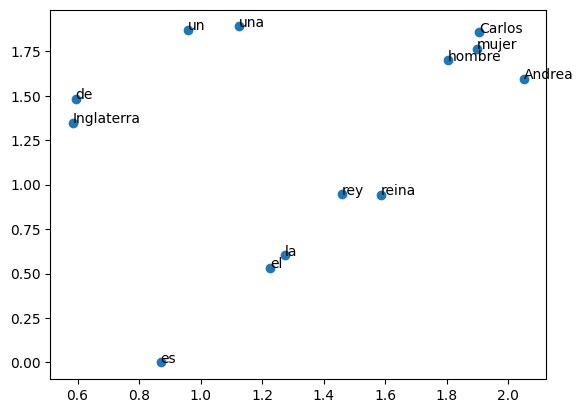

In [213]:
import matplotlib.pyplot as plt
x=[]
y=[]
for key, value in embedding_dic.items():
  x.append(embedding_dic[key][0][0][0])
  y.append(embedding_dic[key][0][0][1])
  #words.append(source_token_dict_inv[key])
plt.scatter(x, y)

for key, value in embedding_dic.items():
  plt.annotate(source_token_dict_inv[key], (embedding_dic[key][0][0][0], embedding_dic[key][0][0][1]))


In [205]:
key=source_token_dict['rey']
print(key)

1


In [226]:
embedding_of_rey = embedding_dic[source_token_dict['rey']]
print(embedding_of_rey)

[array([[1.46014078, 0.9449566 ]])]


In [227]:
embedding_of_hombre = embedding_dic[source_token_dict['hombre']]
print(embedding_of_hombre)

[array([[1.80458412, 1.69887448]])]


In [228]:
embedding_of_mujer = embedding_dic[source_token_dict['mujer']]
print(embedding_of_mujer)

[array([[1.89748671, 1.76297155]])]


In [229]:
analogia = embedding_of_rey[0]-embedding_of_hombre[0]+embedding_of_mujer[0]
print(analogia)
distances={}
for key, value in embedding_dic.items():
  distance=cosine_similarity(analogia, value)
  distances[source_token_dict_inv[key]]=distance
sorted_similarities = sorted(distances.items(), key=lambda x: x[1])
print(sorted_similarities[0])
print(embedding_dic[source_token_dict[sorted_similarities[0][0]]])
print(embedding_dic[8])#source_token_dict[sorted_similarities[0][0]]])

[[1.55304337 1.00905367]]
('reina', 0.07331122787055243)
[array([[1.58570251, 0.94341895]])]
[array([[1.58570251, 0.94341895]])]


In [26]:
def cosine_similarity(v1, v2):
  #return (np.array(v1)@np.array(v2))/(np.linalg.norm(v1)*np.linalg.norm(v2))
  return np.sqrt(np.sum((np.power((v1-v2),2))))

In [27]:
def most_similar(word, word_dict, top_k=4):
  if word not in word_dict:
    raise ValueError(f"{word} not found in the dictionary")
  else:
    key = word_dict[word]

    queryVector = embedding_dic[key]

    similarities = {}
    for key2, value in embedding_dic.items():
      if key!=key2:
        similarity = cosine_similarity(queryVector[0][0], value[0][0])
        similarities[source_token_dict_inv[key2]]=similarity
  sorted_similarities = sorted(similarities.items(), key=lambda x: x[1])
  return sorted_similarities[:top_k]

In [178]:
most_similar('Carlos', source_token_dict, 4)

[('hombre', 0.17498751755596204),
 ('Andrea', 0.18590348807721163),
 ('mujer', 0.2943504966882905),
 ('una', 0.5207554485750954)]

**Ahora veremos el término "Positional Encoding"**

In [ ]:
def get_positionalEncoding(len_Sentence, dim_embedding):
  pos = np.arange(len_Sentence)[:, np.newaxis]
  angle_rads = pos / np.power(10000, (2 * (np.arange(dim_embedding) // 2)) / np.float32(dim_embedding))
  # Aplicar seno a los índices pares en el arreglo
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  # Aplicar coseno a los índices impares en el arreglo
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
  return angle_rads

In [ ]:
positional_encoding = get_positionalEncoding(7, 2)
for vector in positional_encoding:
  print(vector)

[0. 1.]
[0.84147098 0.54030231]
[ 0.90929743 -0.41614684]
[ 0.14112001 -0.9899925 ]
[-0.7568025  -0.65364362]
[-0.95892427  0.28366219]
[-0.2794155   0.96017029]


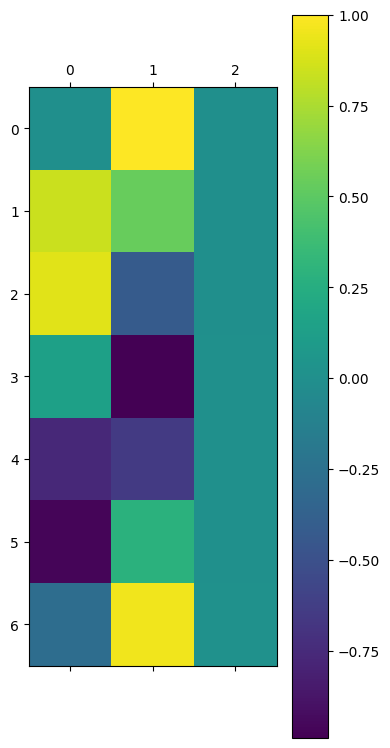

In [ ]:
import matplotlib.pyplot as plt
P = get_positionalEncoding(7, 3)
cax = plt.matshow(P)
plt.gcf().colorbar(cax)

Sumamos el embedding + la codificación posicional para la frase **la reina de inglarterra es una mujer**

In [ ]:
embedding_of_sentence = embedding.getEmbedding(encoder_input[1])
print("Embedding")
for value in embedding_of_sentence:
  print(value[0])
print("\nPositional Encoding")
for value in np.array(positional_encoding):
  print(value)
print("\nInput for Encoder")
for i in range(len(embedding_of_sentence)):
  print(embedding_of_sentence[i][0]+np.array(positional_encoding)[i])


Embedding
[4.36784609 0.03817434]
[5.66969563 0.        ]
[0. 0.]
[1.26963357 0.        ]
[7.23264316 0.        ]
[0. 0.]
[5.52944602 0.12864978]

Positional Encoding
[0. 1.]
[0.84147098 0.54030231]
[ 0.90929743 -0.41614684]
[ 0.14112001 -0.9899925 ]
[-0.7568025  -0.65364362]
[-0.95892427  0.28366219]
[-0.2794155   0.96017029]

Input for Encoder
[4.36784609 1.03817434]
[6.51116662 0.54030231]
[ 0.90929743 -0.41614684]
[ 1.41075358 -0.9899925 ]
[ 6.47584067 -0.65364362]
[-0.95892427  0.28366219]
[5.25003052 1.08882006]


In [ ]:
import numpy as np

In [ ]:
np.sqrt(np.sum(np.power(np.array([3, 2, 5])-np.array([2, 2, 2]), 2)))

3.1622776601683795